# Regression With NEON Data

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

from micropyome.taxa import regression
from micropyome.datasets import normalize, normalize_categories

## Regression on Fungi

In [2]:
TRANSFER_DATASET_PATH = "data/averill_tranfer"
SAMPLING_LEVELS = ["core", "plot", "site"]

X = {}
Y = {}
averill_results = {}

for level in regression.TAXONOMIC_LEVELS:
    X[level] = {}
    Y[level] = {}
    averill_results[level] = {}
    for sampling in SAMPLING_LEVELS:
        x = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Variables/{level}_{sampling}_13Var.csv", delimiter=";")
        x = x.drop(x.columns[0], axis=1)
        x = normalize(x)
        y = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Observed/{level}_{sampling}_observed.csv")
        y = y.drop(y.columns[0], axis=1)
        y = normalize_categories(y)
        z = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Predicted/{level}_{sampling}_predicted.csv")
        z = z.drop(z.columns[0], axis=1)
        z = normalize_categories(z)
        X[level][sampling] = x
        Y[level][sampling] = y
        averill_results[level][sampling] = z

In [4]:
for level in Y:
    print(level, "    ", Y[level]["core"].shape)

fg      (317, 6)
phylum      (317, 5)
class      (317, 10)
order      (317, 20)
family      (317, 21)
genus      (317, 16)


In [12]:
X["fg"]["core"].head()

,pC,cn,pH,NPP,map,mat,forest,conifer,relEM,P,K,Ca,Mg
0,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
1,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
2,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
3,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
4,0.449557,0.461103,0.107240,0.659976,0.800551,0.104998,1.0,1.0,0.634757,0.254657,0.264546,0.807743,0.861824


In [13]:
Y["fg"]["core"].head()

,other,Saprotroph,Ectomycorrhizal,Wood_Saprotroph,Animal_Pathogen,Plant_Pathogen
0,0.278330,0.169980,0.547714,0.001988,0.000994,0.000994
1,0.088469,0.344930,0.545726,0.012922,0.000994,0.006958
2,0.000994,0.007952,0.988072,0.000994,0.000994,0.000994
3,0.772366,0.075547,0.143141,0.006958,0.000994,0.000994
4,0.380716,0.147117,0.441352,0.028827,0.000994,0.000994


In [14]:
averill_results["fg"]["core"].head()

,mean.other,mean.Saprotroph,mean.Ectomycorrhizal,mean.Wood_Saprotroph,mean.Animal_Pathogen,mean.Plant_Pathogen
0,0.169523,0.349924,0.318562,0.095838,0.030913,0.035241
1,0.169948,0.350793,0.317564,0.095564,0.030968,0.035163
2,0.171233,0.351855,0.315821,0.094760,0.031213,0.035119
3,0.171406,0.349828,0.316899,0.095593,0.031033,0.035241
4,0.197384,0.427429,0.180244,0.115199,0.034781,0.044962


In [15]:
for level in X:
    for sampling in X[level]:
        print(f"{level} {sampling}: {len(X[level][sampling])}")

fg core: 317
fg plot: 100
fg site: 12
phylum core: 317
phylum plot: 100
phylum site: 12
class core: 317
class plot: 100
class site: 12
order core: 317
order plot: 100
order site: 12
family core: 317
family plot: 100
family site: 12
genus core: 317
genus plot: 100
genus site: 12


In [16]:
models = {
    "k-NN": KNeighborsRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
    "Kernel Ridge": KernelRidge()
}

In [17]:
results = {}

for level in X:
    results[level] = {}
    for sampling in X[level]:
        N = len(X[level][sampling])
        M = len(Y[level][sampling].loc[0])
        results[level][sampling] = {"N": N, "n_categories": M}
        x_train, x_test, y_train, y_test = train_test_split(
            X[level][sampling], Y[level][sampling], test_size=0.2
        )
        for model in models:
            models[model].fit(x_train, y_train)
            r = regression.evaluate(models[model], x_test, y_test, threshold=0.01)
            results[level][sampling][model] = np.mean(r)

print(json.dumps(results, indent=4))

{
    "fg": {
        "core": {
            "N": 317,
            "n_categories": 6,
            "k-NN": 0.3812645546456549,
            "Linear Regression": 0.4385496547747102,
            "Decision Tree": 0.032329794167955894,
            "Random Forest": 0.46173659017497026,
            "Gradient Boosting": 0.45050119820502027,
            "Kernel Ridge": 0.3903028257299098
        },
        "plot": {
            "N": 100,
            "n_categories": 6,
            "k-NN": 0.39481801678637823,
            "Linear Regression": 0.465348752046024,
            "Decision Tree": -0.08358640367953503,
            "Random Forest": 0.242852279357384,
            "Gradient Boosting": 0.20174907698807168,
            "Kernel Ridge": 0.4570295705520843
        },
        "site": {
            "N": 12,
            "n_categories": 6,
            "k-NN": 0.06504035161174589,
            "Linear Regression": 0.4862709471452101,
            "Decision Tree": -0.5851815651644666,
            "Random 

In [18]:
def graph(model_name: str, cutoff: float = None):
    x = list(range(len(SAMPLING_LEVELS)))
    for level in regression.TAXONOMIC_LEVELS:
        r = [results[level][sampling][model_name] for sampling in results[level]]
        if cutoff and sum(r) < cutoff:
            continue
        plt.plot(x, r, "-o", label=level)

    plt.xticks(x, SAMPLING_LEVELS)
    plt.legend()
    plt.title(model_name)
    plt.show()

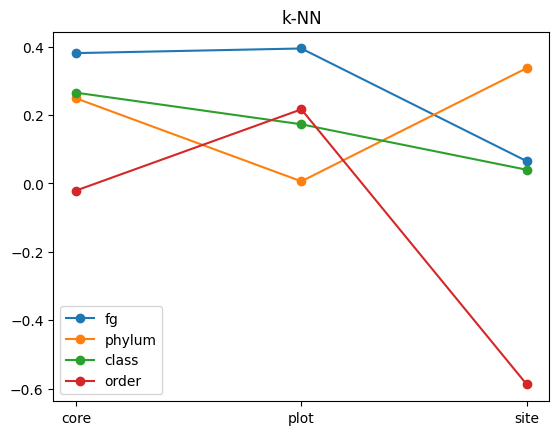

In [19]:
graph("k-NN", -2)

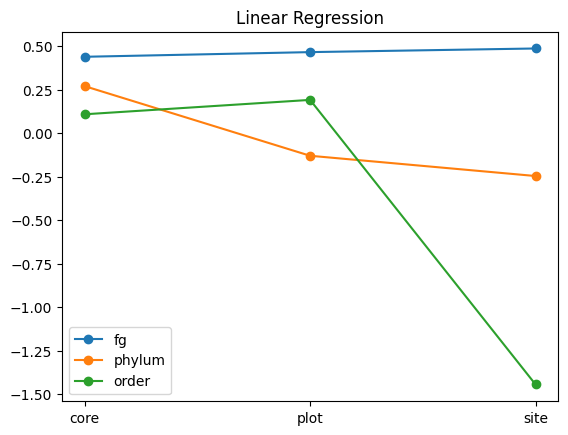

In [20]:
graph("Linear Regression", -2)

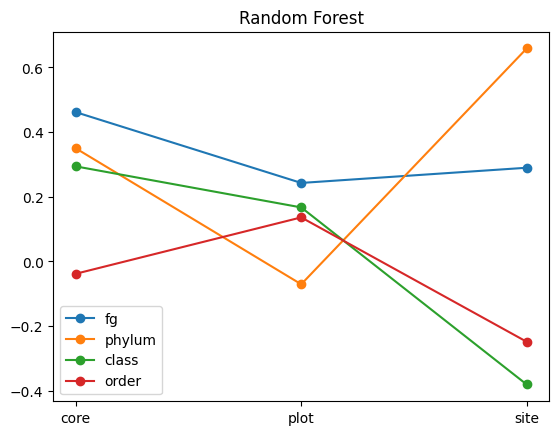

In [21]:
graph("Random Forest", -2)

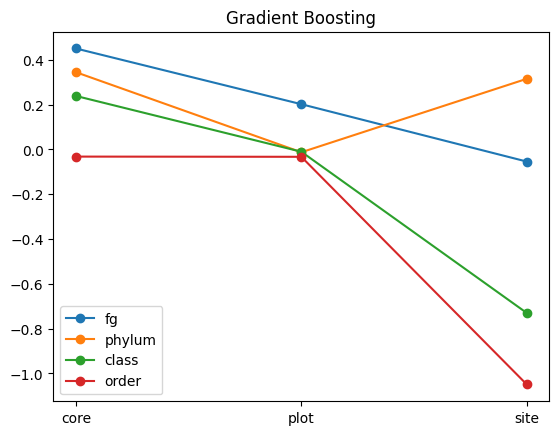

In [22]:
graph("Gradient Boosting", -2)

In [23]:
X_core = {}
Y_core = {}

for level in regression.TAXONOMIC_LEVELS:
    X_core[level] = X[level]["core"]
    Y_core[level] = Y[level]["core"]

models = {
    "k-NN": KNeighborsRegressor(20),
    "Linear Regression": LinearRegression(),
    #"Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
    #"Kernel Ridge": KernelRidge()
}

results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, k_fold=5)

2024-06-13T09:10:17.055496 > INFO Evaluating 4 models with 5 splits.
2024-06-13T09:10:17.056993 > INFO Level: fg
2024-06-13T09:10:17.059427 > INFO K-fold split: 0
2024-06-13T09:10:17.065914 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:17.562827 > INFO K-fold split: 1
2024-06-13T09:10:17.565978 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:18.103398 > INFO K-fold split: 2
2024-06-13T09:10:18.106903 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:18.621436 > INFO K-fold split: 3
2024-06-13T09:10:18.623827 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:19.125103 > INFO K-fold split: 4
2024-06-13T09:10:19.129701 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:19.623455 > INFO Level: phylum
2024-06-13T09:10:19.631051 > INFO K-fold split: 0
2024-06-13T09:10:19.633684 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:20.076015 > INFO K-fold split: 1
2024-06-13T09:10:20.078444 > INFO Beginning the evaluatio

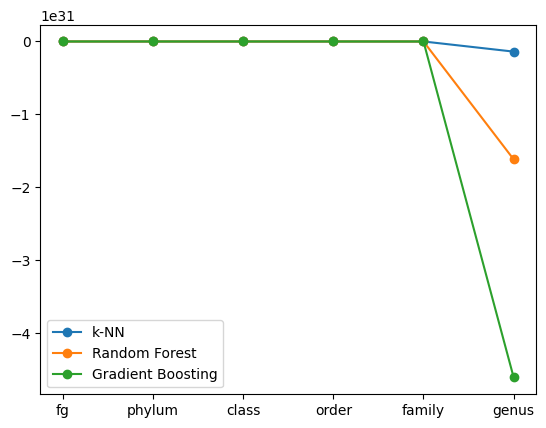

In [24]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    if model == "Decision Tree" or model == "Linear Regression":
        continue
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

In [25]:
print(json.dumps(results, indent=4))

{
    "fg": {
        "k-NN": 0.344290933562939,
        "Linear Regression": 0.3217432454014508,
        "Random Forest": 0.3706804761180279,
        "Gradient Boosting": 0.3168304301323022
    },
    "phylum": {
        "k-NN": 0.2852334839960239,
        "Linear Regression": 0.29735933375532453,
        "Random Forest": 0.224042384410214,
        "Gradient Boosting": 0.2118849866845171
    },
    "class": {
        "k-NN": 0.2147040467463733,
        "Linear Regression": 0.21796749552512243,
        "Random Forest": -0.03465765551405457,
        "Gradient Boosting": -0.0895134251987281
    },
    "order": {
        "k-NN": 0.07925371211363327,
        "Linear Regression": -0.02602766438761206,
        "Random Forest": -0.6473543247480574,
        "Gradient Boosting": -2.193346839431004
    },
    "family": {
        "k-NN": -0.10938528514598737,
        "Linear Regression": -2.437200760061822e+26,
        "Random Forest": -1.4907820613819884,
        "Gradient Boosting": -2.29354004

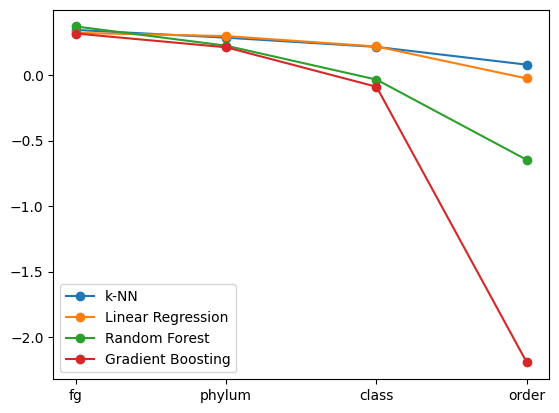

In [26]:
levels = ("fg", "phylum", "class", "order")
x = list(range(len(levels)))

for model in models:
    y = [results[level][model] for level in levels]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, levels)
plt.legend()
plt.show()

In [27]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.01, k_fold=5)

2024-06-13T09:10:44.485781 > INFO Evaluating 4 models with 5 splits.
2024-06-13T09:10:44.487886 > INFO Level: fg
2024-06-13T09:10:44.489075 > INFO K-fold split: 0
2024-06-13T09:10:44.493285 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:44.998575 > INFO K-fold split: 1
2024-06-13T09:10:45.003000 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:45.501399 > INFO K-fold split: 2
2024-06-13T09:10:45.504659 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:45.998591 > INFO K-fold split: 3
2024-06-13T09:10:46.001729 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:46.499841 > INFO K-fold split: 4
2024-06-13T09:10:46.503395 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:47.011715 > INFO Level: phylum
2024-06-13T09:10:47.012531 > INFO K-fold split: 0
2024-06-13T09:10:47.016466 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:10:47.443052 > INFO K-fold split: 1
2024-06-13T09:10:47.453309 > INFO Beginning the evaluatio

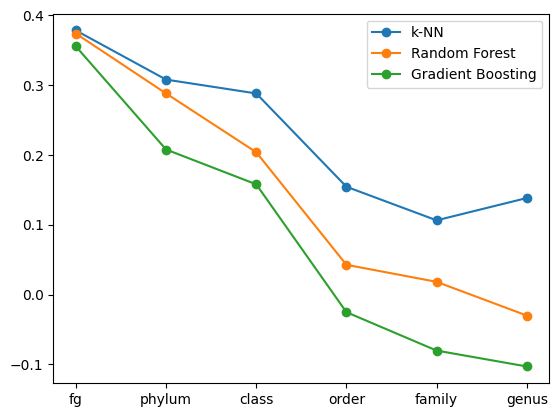

In [28]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    if model == "Decision Tree" or model == "Linear Regression":
        continue
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

In [29]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.02, k_fold=5)

2024-06-13T09:11:12.269530 > INFO Evaluating 4 models with 5 splits.
2024-06-13T09:11:12.270575 > INFO Level: fg
2024-06-13T09:11:12.272590 > INFO K-fold split: 0
2024-06-13T09:11:12.276902 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:12.770560 > INFO K-fold split: 1
2024-06-13T09:11:12.773739 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:13.276294 > INFO K-fold split: 2
2024-06-13T09:11:13.279443 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:13.781488 > INFO K-fold split: 3
2024-06-13T09:11:13.785053 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:14.292992 > INFO K-fold split: 4
2024-06-13T09:11:14.299045 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:14.793425 > INFO Level: phylum
2024-06-13T09:11:14.793425 > INFO K-fold split: 0
2024-06-13T09:11:14.799550 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:15.243587 > INFO K-fold split: 1
2024-06-13T09:11:15.247454 > INFO Beginning the evaluatio

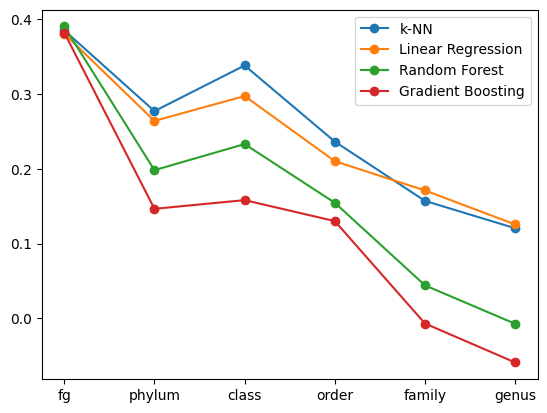

In [30]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

2024-06-13T09:11:40.019458 > INFO Evaluating 4 models with 5 splits.
2024-06-13T09:11:40.021601 > INFO Level: fg
2024-06-13T09:11:40.022625 > INFO K-fold split: 0
2024-06-13T09:11:40.026799 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:40.536341 > INFO K-fold split: 1
2024-06-13T09:11:40.542362 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:41.059382 > INFO K-fold split: 2
2024-06-13T09:11:41.063038 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:41.569231 > INFO K-fold split: 3
2024-06-13T09:11:41.572807 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:42.083138 > INFO K-fold split: 4
2024-06-13T09:11:42.083138 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:42.591636 > INFO Level: phylum
2024-06-13T09:11:42.592646 > INFO K-fold split: 0
2024-06-13T09:11:42.597098 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:11:43.040167 > INFO K-fold split: 1
2024-06-13T09:11:43.043258 > INFO Beginning the evaluatio

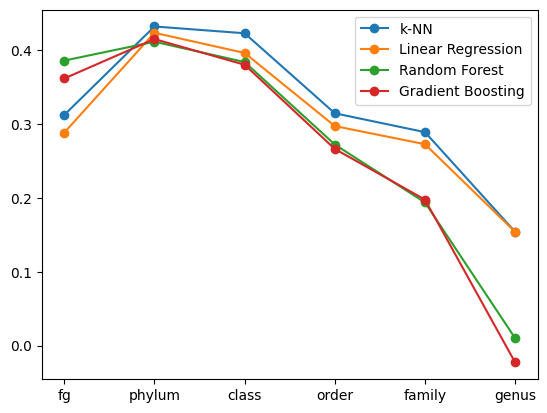

In [31]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.06, k_fold=5)
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

In [32]:
from random import randint

gradient_boosting_parameters = {
    'estimator__n_estimators': [randint(80, 120)],  # Close to default of 100
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],  # Default is 0.1
    'estimator__max_depth': [3, 4, 5, 6, 7, 8],  # Default is 3
    'estimator__min_samples_split': list(range(2, 10)),  # Default is 2
    'estimator__min_samples_leaf': list(range(1, 6)),  # Default is 1
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # Default is None
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Default is 1.0
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

params = {}
for level in regression.TAXONOMIC_LEVELS:
    print(level)
    model = MultiOutputRegressor(GradientBoostingRegressor())
    search = RandomizedSearchCV(model, gradient_boosting_parameters, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level]["core"], Y[level]["core"], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

for level in regression.TAXONOMIC_LEVELS:
    model = MultiOutputRegressor(GradientBoostingRegressor(**params[level]))
    model.fit(X[level]["core"], Y[level]["core"])
    r = regression.evaluate(model, x_test, y_test, "other", 0.06)

fg
phylum
class
order
family
genus


TypeError: GradientBoostingRegressor.__init__() got an unexpected keyword argument 'estimator__subsample'

In [ ]:
print(json.dumps(params, indent=4))

{
    "fg": {
        "estimator__subsample": 0.6,
        "estimator__n_estimators": 104,
        "estimator__min_samples_split": 6,
        "estimator__min_samples_leaf": 4,
        "estimator__max_features": "log2",
        "estimator__max_depth": 3,
        "estimator__learning_rate": 0.05
    },
    "phylum": {
        "estimator__subsample": 0.7,
        "estimator__n_estimators": 104,
        "estimator__min_samples_split": 9,
        "estimator__min_samples_leaf": 1,
        "estimator__max_features": 0.5,
        "estimator__max_depth": 3,
        "estimator__learning_rate": 0.05
    },
    "class": {
        "estimator__subsample": 0.8,
        "estimator__n_estimators": 104,
        "estimator__min_samples_split": 4,
        "estimator__min_samples_leaf": 4,
        "estimator__max_features": "log2",
        "estimator__max_depth": 3,
        "estimator__learning_rate": 0.05
    },
    "order": {
        "estimator__subsample": 0.6,
        "estimator__n_estimators": 104,
  

In [47]:
params = {
    "fg": {
        "subsample": 0.6,
        "n_estimators": 104,
        "min_samples_split": 6,
        "min_samples_leaf": 4,
        "max_features": "log2",
        "max_depth": 3,
        "learning_rate": 0.05
    },
    "phylum": {
        "subsample": 0.7,
        "n_estimators": 104,
        "min_samples_split": 9,
        "min_samples_leaf": 1,
        "max_features": 0.5,
        "max_depth": 3,
        "learning_rate": 0.05
    },
    "class": {
        "subsample": 0.8,
        "n_estimators": 104,
        "min_samples_split": 4,
        "min_samples_leaf": 4,
        "max_features": "log2",
        "max_depth": 3,
        "learning_rate": 0.05
    },
    "order": {
        "subsample": 0.6,
        "n_estimators": 104,
        "min_samples_split": 2,
        "min_samples_leaf": 4,
        "max_features": "log2",
        "max_depth": 3,
        "learning_rate": 0.05
    },
    "family": {
        "subsample": 0.6,
        "n_estimators": 104,
        "min_samples_split": 4,
        "min_samples_leaf": 5,
        "max_features": 0.8,
        "max_depth": 7,
        "learning_rate": 0.05
    },
    "genus": {
        "subsample": 0.9,
        "n_estimators": 104,
        "min_samples_split": 3,
        "min_samples_leaf": 1,
        "max_features": 0.5,
        "max_depth": 5,
        "learning_rate": 0.15
    }
}


for level in regression.TAXONOMIC_LEVELS:
    model = MultiOutputRegressor(GradientBoostingRegressor(**params[level]))
    model.fit(x_train, y_train)
    r = regression.evaluate(model, x_test, y_test, "other", 0.06)
    results[level]["GradientBoosting"] = np.mean(r)

In [57]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

for level in regression.TAXONOMIC_LEVELS:
    model = LogitRegression()
    model.fit(x_train, y_train)
    r = regression.evaluate(model, x_test, y_test, "other", 0.06)
    results[level]["Logit"] = np.mean(r)

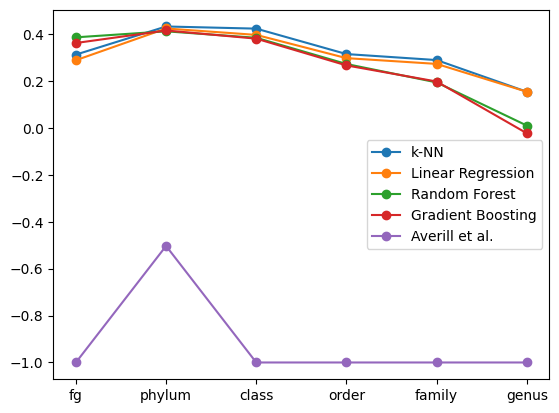

In [67]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

model_names = list(models.keys()) + ["Logit"]
for model in model_names:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = np.mean(regression.r2_score_by_column(Y[level]["core"], averill_results[level]["core"]))
    if r < -1:
        published_results.append(-1)
    else:
        published_results.append(r)
#plt.plot(x, published_results, "-o", label="Averill et al.")

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

## Regression with Bacteria

In [5]:
DATASET_PATH = "data/neon/bacteria"
SAMPLING_LEVELS = ["core", "plot", "site"]

TAXONOMIC_LEVELS = regression.TAXONOMIC_LEVELS
if "fg" in TAXONOMIC_LEVELS:
    TAXONOMIC_LEVELS.remove("fg")

X = {}
Y = {}
averill_results = {}

for level in TAXONOMIC_LEVELS:
    X[level] = {}
    Y[level] = {}
    averill_results[level] = {}
    for sampling in SAMPLING_LEVELS:
        x = pd.read_csv(f"{DATASET_PATH}/variables/{level}_{sampling}.preds")
        x = x.drop([x.columns[0], x.columns[1], x.columns[2], x.columns[3]], axis=1)
        x = normalize(x)
        y = pd.read_csv(f"{DATASET_PATH}/observed/{level}_{sampling}.fit_mean.csv")
        y = y.drop(y.columns[0], axis=1)
        y = normalize_categories(y)
        z = pd.read_csv(f"{DATASET_PATH}/predicted/{level}_{sampling}.fit.csv")
        z = z.drop(z.columns[0], axis=1)
        z = normalize_categories(z)
        X[level][sampling] = x
        Y[level][sampling] = y
        averill_results[level][sampling] = z

In [3]:
X_core = {}
Y_core = {}

for level in regression.TAXONOMIC_LEVELS:
    X_core[level] = X[level]["core"]
    Y_core[level] = Y[level]["core"]

models = {
    "k-NN": KNeighborsRegressor(20),
    "Linear Regression": LinearRegression(),
    #"Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
    #"Kernel Ridge": KernelRidge()
}

2024-06-23T15:51:28.149018 > INFO Evaluating 4 models with 5 splits.
2024-06-23T15:51:28.150665 > INFO Level: phylum
2024-06-23T15:51:28.169636 > INFO K-fold split: 0
2024-06-23T15:51:28.174415 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:29.338841 > INFO K-fold split: 1
2024-06-23T15:51:29.343923 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:30.233868 > INFO K-fold split: 2
2024-06-23T15:51:30.242005 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:31.129615 > INFO K-fold split: 3
2024-06-23T15:51:31.133136 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:32.023046 > INFO K-fold split: 4
2024-06-23T15:51:32.026267 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:32.922741 > INFO Level: class
2024-06-23T15:51:32.922741 > INFO K-fold split: 0
2024-06-23T15:51:32.929952 > INFO Beginning the evaluation of 4 models.
2024-06-23T15:51:34.760650 > INFO K-fold split: 1
2024-06-23T15:51:34.763777 > INFO Beginning the evalua

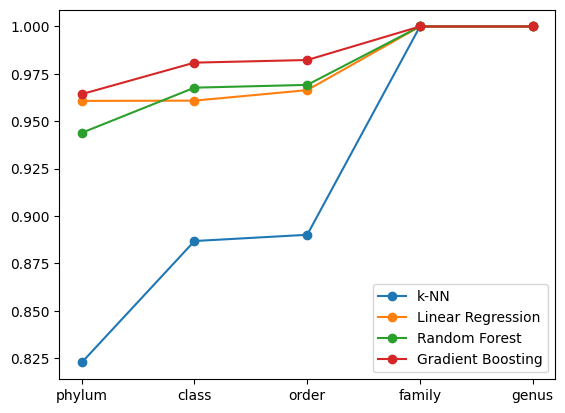

In [4]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.06, k_fold=5)
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = np.mean(regression.r2_score_by_column(Y[level]["core"], averill_results[level]["core"]))
    if r < -1:
        published_results.append(-1)
    else:
        published_results.append(r)
#plt.plot(x, published_results, "-o", label="Averill et al.")

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

2024-06-13T10:16:45.439187 > INFO Evaluating 4 models with 5 splits.
2024-06-13T10:16:45.440188 > INFO Level: phylum
2024-06-13T10:16:45.442711 > INFO K-fold split: 0
2024-06-13T10:16:45.448519 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:46.467084 > INFO K-fold split: 1
2024-06-13T10:16:46.472595 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:47.541523 > INFO K-fold split: 2
2024-06-13T10:16:47.547640 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:48.516464 > INFO K-fold split: 3
2024-06-13T10:16:48.523555 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:49.494355 > INFO K-fold split: 4
2024-06-13T10:16:49.499110 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:50.507926 > INFO Level: class
2024-06-13T10:16:50.509928 > INFO K-fold split: 0
2024-06-13T10:16:50.514840 > INFO Beginning the evaluation of 4 models.
2024-06-13T10:16:52.544934 > INFO K-fold split: 1
2024-06-13T10:16:52.548448 > INFO Beginning the evalua

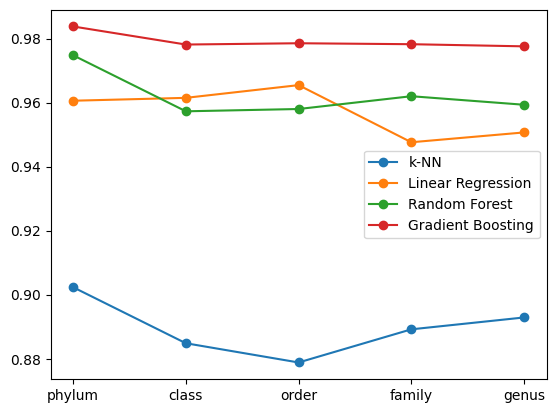

In [82]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.001, k_fold=5)
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = np.mean(regression.r2_score_by_column(Y[level]["core"], averill_results[level]["core"]))
    if r < -1:
        published_results.append(-1)
    else:
        published_results.append(r)
#plt.plot(x, published_results, "-o", label="Averill et al.")

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

2024-06-13T09:38:39.363076 > INFO Evaluating 4 models with 5 splits.
2024-06-13T09:38:39.365297 > INFO Level: phylum
2024-06-13T09:38:39.367306 > INFO K-fold split: 0
2024-06-13T09:38:39.370475 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:40.271093 > INFO K-fold split: 1
2024-06-13T09:38:40.274842 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:41.132849 > INFO K-fold split: 2
2024-06-13T09:38:41.136513 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:41.991454 > INFO K-fold split: 3
2024-06-13T09:38:41.995574 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:42.867110 > INFO K-fold split: 4
2024-06-13T09:38:42.870946 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:43.724104 > INFO Level: class
2024-06-13T09:38:43.726111 > INFO K-fold split: 0
2024-06-13T09:38:43.729711 > INFO Beginning the evaluation of 4 models.
2024-06-13T09:38:45.450083 > INFO K-fold split: 1
2024-06-13T09:38:45.453699 > INFO Beginning the evalua

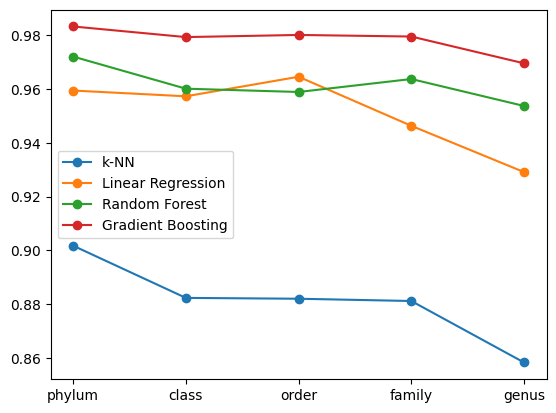

In [79]:
results = regression.train_evaluate_models_multiple_taxa(models, X_core, Y_core, threshold=0.01, k_fold=5)
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

## 16S NEON Data

In [52]:
_16S_DATASET_PATH = "data/neon/16s_groups"

ABUNDANCES = {}

for level in ("phylum", "class", "order", "family", "genus"):
    ABUNDANCES[level] = pd.read_csv(f"{_16S_DATASET_PATH}/{level}_rel.abundances.csv")

X = {}
Y = {}
averill_results = {}

def eliminate_absent_rows(a: pd.DataFrame, x) -> pd.DataFrame:
    indices = []
    present = []
    for i in range(x.shape[0]):
        present.append(
            x.loc[i]["sampleID"].replace("_", ".").replace("-", ".")
        )


for level in TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}/variables/{level}_core.preds")
    meta = x.drop(x.columns[4:], axis=1)
    data = x.drop([x.columns[0], x.columns[1], x.columns[2], x.columns[3]], axis=1)
    data = normalize(data)
    x = pd.concat([meta, data], axis=1)
    y = pd.read_csv(f"{DATASET_PATH}/observed/{level}_core.fit_mean.csv")
    y = y.drop(y.columns[0], axis=1)
    y = normalize_categories(y)
    z = pd.read_csv(f"{DATASET_PATH}/predicted/{level}_core.fit.csv")
    z = z.drop(z.columns[0], axis=1)
    z = normalize_categories(z)
    X[level] = x
    Y[level] = y
    averill_results[level] = z

In [51]:
ABUNDANCES["genus"].loc[0]

Unnamed: 0          BART.001.21.1.6.O.20140619
other                                   0.9408
bacillus                                   0.0
bradyrhizobium                          0.0038
chthoniobacter                          0.0006
devosia                                    0.0
mycobacterium                           0.0006
opitutus                                 0.005
phenylobacterium                           0.0
pseudomonas                                0.0
rhodoplanes                             0.0492
sphingomonas                               0.0
Name: 0, dtype: object

In [59]:
X["genus"].loc[0]

Unnamed: 0                          1
siteID                           BART
plotID                       BART_001
sampleID      BART_001-M-1-6-20140619
pH                           0.198217
pC                           0.390323
cn                           0.493139
relEM                        0.687151
map                          0.802026
mat                          0.105142
NPP                          0.659976
forest                            1.0
conifer                           1.0
Name: 0, dtype: object